In [3]:
import pandas as pd
import numpy as np
import sqlite3

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [4]:
con = sqlite3.connect("../db.sqlite3")
pd.read_sql(
    "SELECT restaurant_order.datetime, "
    "restaurant_orderitem.quantity, "
    "restaurant_product.price,  "
    "restaurant_product.name "
    "FROM restaurant_order "
    "INNER JOIN restaurant_orderitem ON restaurant_order.id = restaurant_orderitem.order_id "
    "INNER JOIN restaurant_product ON restaurant_product.id = restaurant_orderitem.product_id",
    con,
).to_csv("data.csv", index=False)
df = pd.read_csv("data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.shape

(74818, 4)

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

<AxesSubplot: title={'center': 'Top 10 position in menu by quantity'}, ylabel='quantity'>

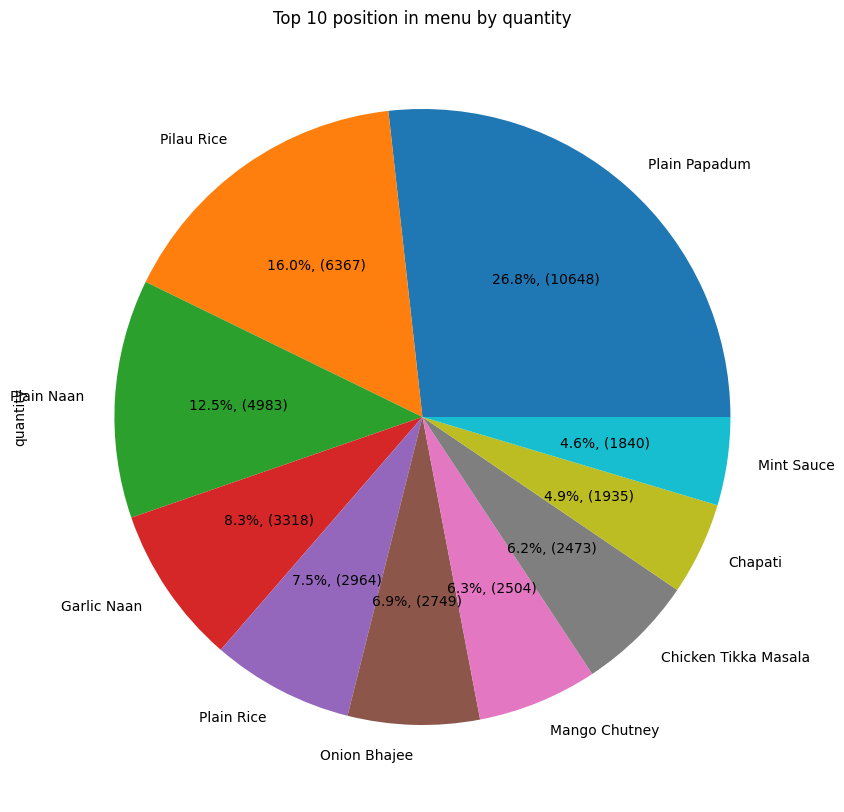

In [5]:
product_counts = df["name"].value_counts().sum()
top_10_products = (
    df.groupby("name")["quantity"].sum().sort_values(ascending=False)[:10]
)
popularity = top_10_products / product_counts

top_10_percentage = (
    lambda percent:
    f"{round(percent, 1)}%, ({round(percent * sum(top_10_products)/100)})"
)

popularity.plot.pie(
    figsize=(10, 10),
    title="Top 10 position in menu by quantity",
    autopct=top_10_percentage
)

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

<AxesSubplot: title={'center': 'Top 10 products which make the most money for restaurant'}, ylabel='item_price'>

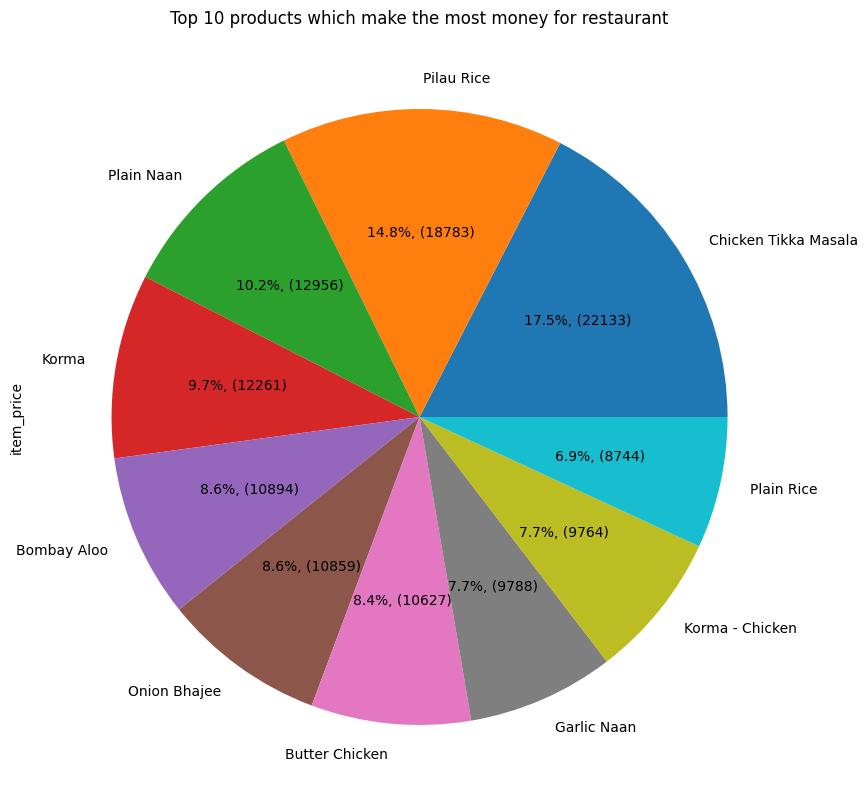

In [117]:
df["item_price"] = df["quantity"] * df["price"]
top_10_profit = (
    df.groupby("name")["item_price"].sum().sort_values(ascending=False)[:10]
)

top_10_profit_percentage = (
    lambda percent:
    f"{round(percent, 1)}%, ({round(percent * sum(top_10_profit)/100)})"
)

top_10_profit.plot.pie(
    figsize=(10, 10),
    title="Top 10 products which make the most money for restaurant",
    autopct=top_10_profit_percentage
)

    # Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

<AxesSubplot: title={'center': 'Profit by order hour'}, xlabel='Order hour', ylabel='Profit'>

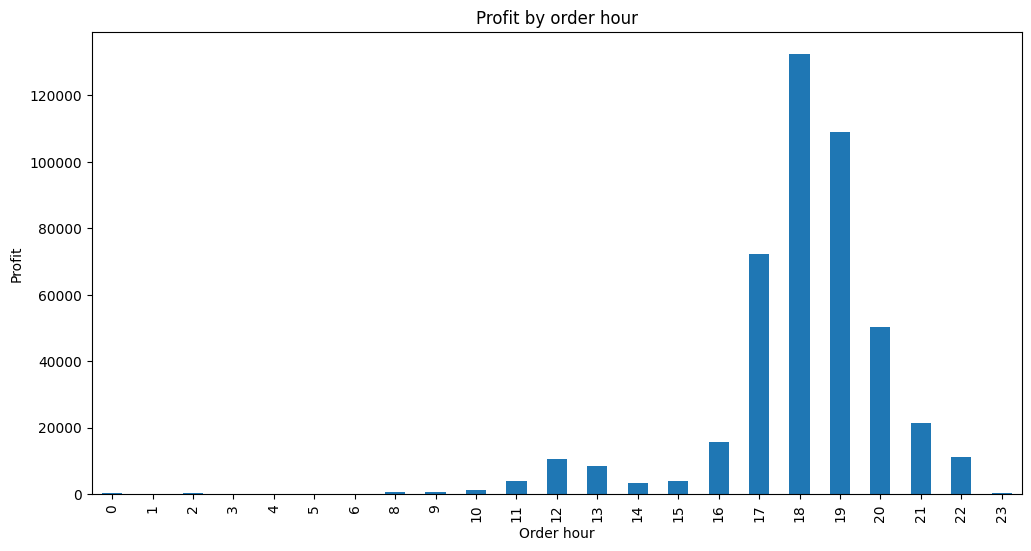

In [70]:
df["order_hour"] = df["datetime"].dt.hour
profit_by_hour = df.groupby("order_hour")["item_price"].sum()

profit_by_hour.plot.bar(
    figsize=(12, 6),
    title="Profit by order hour",
    xlabel="Order hour",
    ylabel="Profit"
)

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

<AxesSubplot: title={'center': 'Profit by day of week'}, xlabel='Week day', ylabel='Profit'>

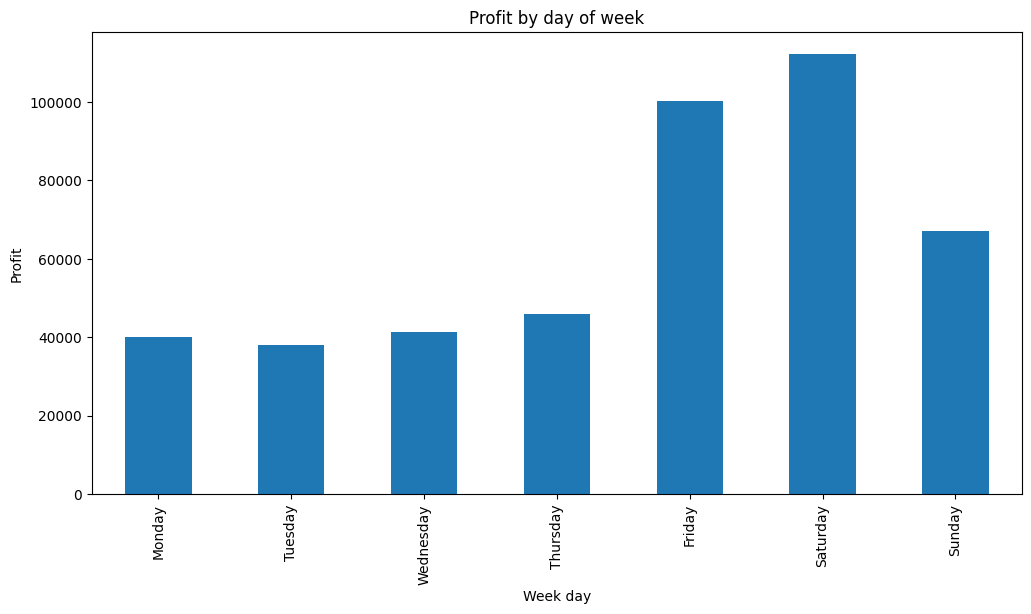

In [118]:
correct_week = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday"
]

df["week_day"] = df["datetime"].dt.day_name()
profit_by_day = df.groupby("week_day")["item_price"].sum().reindex(correct_week)

profit_by_day.plot.bar(
    figsize=(12,6),
    title="Profit by day of week",
    ylabel="Profit",
    xlabel="Week day"
)